Using device: cuda


100%|██████████| 26.4M/26.4M [00:01<00:00, 13.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.1MB/s]


Training ANN...
Epoch 1/5: Train Loss: 0.606, Acc: 78.2% | Val Loss: 0.440, Acc: 83.8%
Epoch 2/5: Train Loss: 0.444, Acc: 84.0% | Val Loss: 0.394, Acc: 85.2%
Epoch 3/5: Train Loss: 0.410, Acc: 85.2% | Val Loss: 0.385, Acc: 85.8%
Epoch 4/5: Train Loss: 0.385, Acc: 86.0% | Val Loss: 0.369, Acc: 86.6%
Epoch 5/5: Train Loss: 0.364, Acc: 86.8% | Val Loss: 0.349, Acc: 87.0%
Training CNN...
Epoch 1/5: Train Loss: 0.562, Acc: 79.5% | Val Loss: 0.345, Acc: 87.2%
Epoch 2/5: Train Loss: 0.374, Acc: 86.3% | Val Loss: 0.301, Acc: 89.0%
Epoch 3/5: Train Loss: 0.329, Acc: 88.0% | Val Loss: 0.261, Acc: 90.5%
Epoch 4/5: Train Loss: 0.299, Acc: 89.0% | Val Loss: 0.244, Acc: 91.0%
Epoch 5/5: Train Loss: 0.274, Acc: 90.0% | Val Loss: 0.227, Acc: 91.8%
ANN Test Accuracy: 86.8%
CNN Test Accuracy: 89.9%


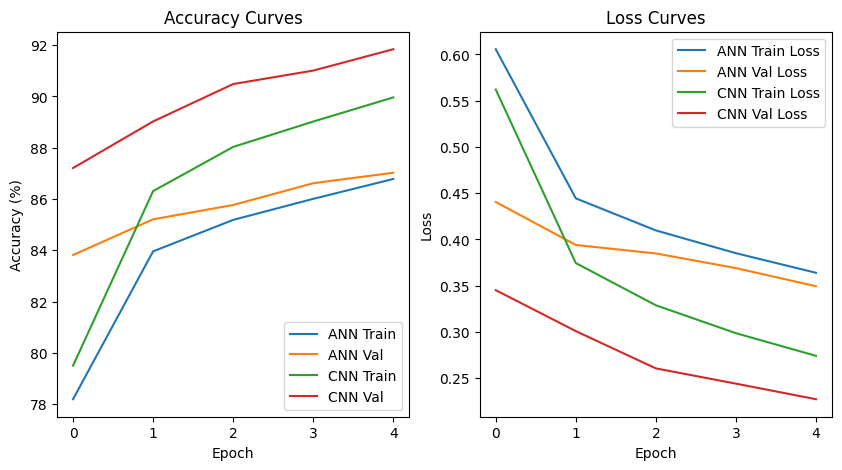

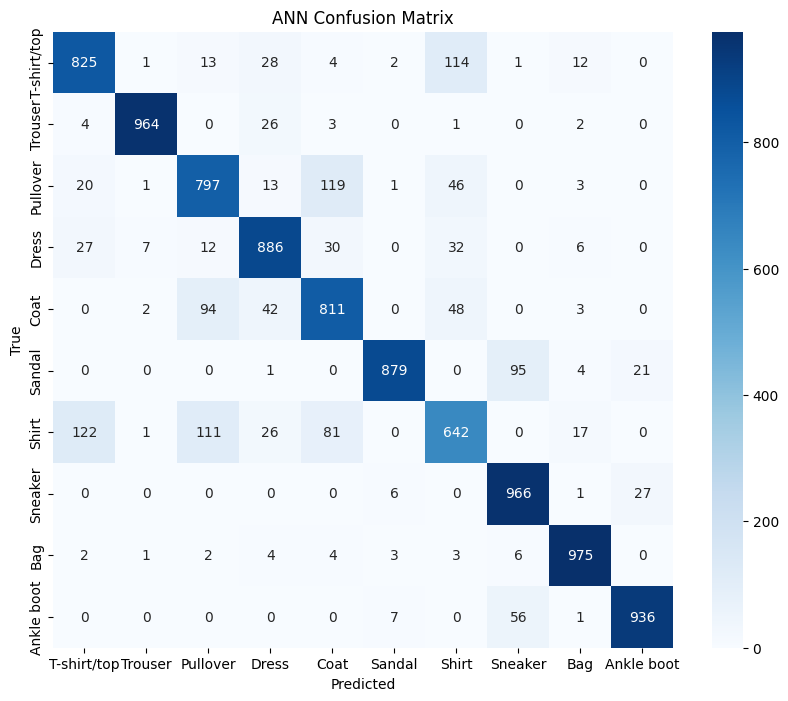

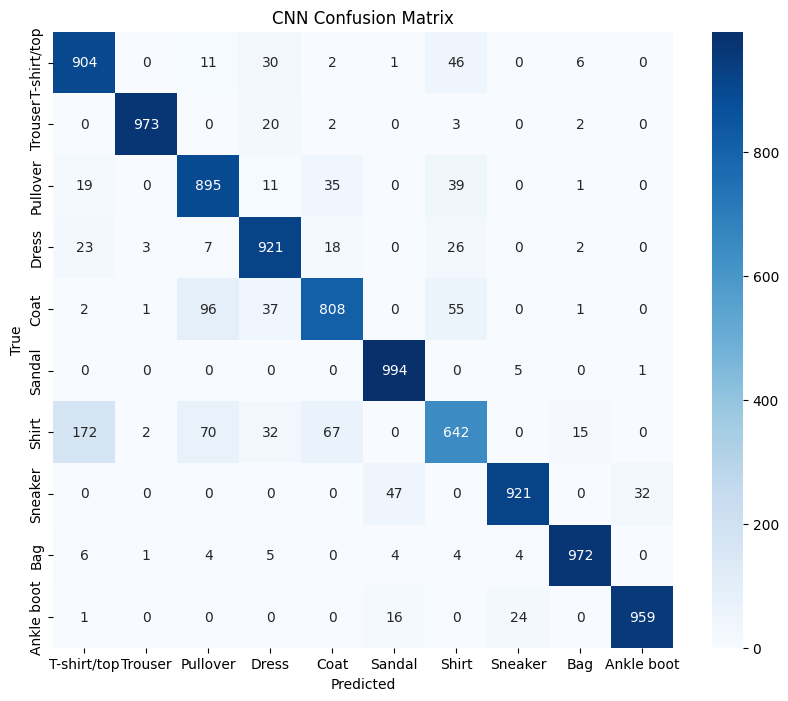

ANN Predictions:


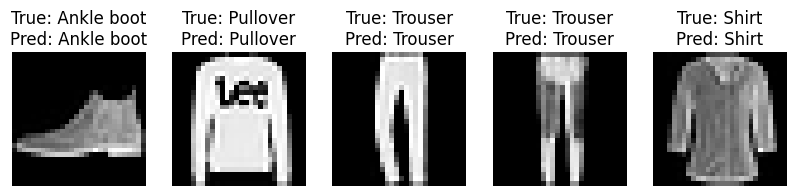

CNN Predictions:


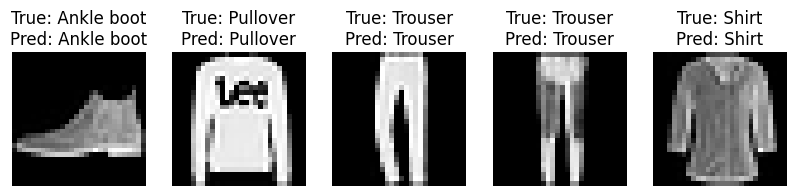

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 1. Load the Dataset and Preprocessing
transform_ann = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

transform_cnn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomRotation(10)  # Augmentation for CNN
])

# Load full training dataset
full_train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform_ann
)

# Split into train and validation (80/20)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Apply different transforms to subsets if needed; here reusing for simplicity
# For CNN, we'll apply augmentation only to train_dataset during loading

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform_ann
)

# DataLoaders
batch_size = 64
train_loader_ann = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# For CNN, create separate train_loader with augmentation
train_dataset_cnn = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform_cnn
)
train_dataset_cnn, _ = random_split(train_dataset_cnn, [train_size, val_size])  # Reuse split
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True)

# Class names
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 2. Model Definitions
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 3. Training Function
def train_model(model, train_loader, val_loader, epochs=5, lr=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss_avg = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val
        val_losses.append(val_loss_avg)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.3f}, Acc: {train_acc:.1f}% | Val Loss: {val_loss_avg:.3f}, Acc: {val_acc:.1f}%')

    return train_losses, val_losses, train_accs, val_accs

# 4. Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    cm = confusion_matrix(all_labels, all_preds)
    return test_acc, cm

# Train ANN
print("Training ANN...")
ann_model = ANN()
ann_train_losses, ann_val_losses, ann_train_accs, ann_val_accs = train_model(ann_model, train_loader_ann, val_loader)

# Train CNN
print("Training CNN...")
cnn_model = CNN()
cnn_train_losses, cnn_val_losses, cnn_train_accs, cnn_val_accs = train_model(cnn_model, train_loader_cnn, val_loader)

# Evaluate
ann_test_acc, ann_cm = evaluate_model(ann_model, test_loader)
cnn_test_acc, cnn_cm = evaluate_model(cnn_model, test_loader)

print(f'ANN Test Accuracy: {ann_test_acc:.1f}%')
print(f'CNN Test Accuracy: {cnn_test_acc:.1f}%')

# Plot Accuracy Curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(ann_train_accs, label='ANN Train')
plt.plot(ann_val_accs, label='ANN Val')
plt.plot(cnn_train_accs, label='CNN Train')
plt.plot(cnn_val_accs, label='CNN Val')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot Loss Curves
plt.subplot(1, 2, 2)
plt.plot(ann_train_losses, label='ANN Train Loss')
plt.plot(ann_val_losses, label='ANN Val Loss')
plt.plot(cnn_train_losses, label='CNN Train Loss')
plt.plot(cnn_val_losses, label='CNN Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix for ANN (example)
plt.figure(figsize=(10, 8))
sns.heatmap(ann_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('ANN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Confusion Matrix for CNN
plt.figure(figsize=(10, 8))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Example predictions (optional)
def show_predictions(model, test_loader, num_images=5):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig = plt.figure(figsize=(10, 4))
    for idx in range(num_images):
        ax = fig.add_subplot(1, num_images, idx+1)
        img = images[idx].cpu().squeeze()
        img = (img * 0.5) + 0.5  # Denormalize
        ax.imshow(img, cmap='gray')
        ax.set_title(f'True: {classes[labels[idx]]}\nPred: {classes[predicted[idx]]}')
        ax.axis('off')
    plt.show()

print("ANN Predictions:")
show_predictions(ann_model, test_loader)
print("CNN Predictions:")
show_predictions(cnn_model, test_loader)